In [171]:
import torch
print(torch.distributed.is_available())        
print(torch.distributed.is_gloo_available())   

True
True


In [172]:
%%writefile distributed_linear_fit.py
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from datetime import timedelta

def setup(rank, world_size):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    # Explicit timeout of 150 minutes
    dist.init_process_group("gloo", rank=rank, world_size=world_size, timeout=timedelta(seconds=9000))

def cleanup():
    if dist.is_initialized():
        dist.destroy_process_group()

def train(rank, world_size, X_full, y_full, epochs=10000, lr=0.001, momentum=0.9):
    setup(rank, world_size)
    
    # Split data among processes
    N = X_full.shape[0]
    local_n = N // world_size
    start = rank * local_n
    end = start + local_n if rank != world_size - 1 else N

    X = X_full[start:end]
    y = y_full[start:end]

    # Initialize weights (same across all processes)
    torch.manual_seed(0)
    if rank == 0:
        w = torch.randn(2, 1, requires_grad=True)
        b = torch.randn(1, requires_grad=True)
    else:
        w = torch.zeros(2, 1, requires_grad=True)
        b = torch.zeros(1, requires_grad=True)
    
    # Broadcast initial weights
    dist.broadcast(w, src=0)
    dist.broadcast(b, src=0)

    # Initialize momentum buffers
    v_w = torch.zeros_like(w)
    v_b = torch.zeros_like(b)

    # Initialize convergence flag
    converged = torch.tensor([0], dtype=torch.int32)

    # Initialize loss history
    losses = []

    print(f"Process {rank} started.")
    
    try:
        for epoch in range(epochs):
            # Forward pass
            y_hat = X @ w + b
            loss = ((y_hat - y)**2).mean()

            # Save loss for visualization
            losses.append(loss.item())

            # Backward pass
            loss.backward()
            
            # Synchronize gradients and apply momentum
            with torch.no_grad():
                grad_w = w.grad.detach().clone()
                grad_b = b.grad.detach().clone()

                dist.all_reduce(grad_w, op=dist.ReduceOp.SUM)
                dist.all_reduce(grad_b, op=dist.ReduceOp.SUM)

                grad_w /= world_size
                grad_b /= world_size

                # Momentum update
                v_w = momentum * v_w + (1 - momentum) * grad_w
                v_b = momentum * v_b + (1 - momentum) * grad_b

                w -= lr * v_w
                b -= lr * v_b

                w.grad.zero_()
                b.grad.zero_()

            # Check for local convergence
            if loss.item() < 1e-7:
                converged[0] = 1
                print(f"Process {rank} converged at epoch {epoch+1}, Loss: {loss.item():.4f}")

            # Synchronize convergence status
            dist.all_reduce(converged, op=dist.ReduceOp.SUM)
            if converged.item() == world_size:  # All processes have converged
                print(f"Process {rank} exiting as all processes converged.")
                break

            # Log from all processes
            if rank == 0 and epoch % 100 == 0:
                print(f"Process {rank}, Epoch {epoch+1}, Loss: {loss.item():.6f}, w = {w.tolist()}, b = {b.item():.4f}")

        # Save losses to file
        torch.save(losses, f"losses_rank_{rank}.pt")

        #torch save the model parameters
        torch.save({'w': w, 'b': b}, f"model_rank_{rank}.pt")

    except RuntimeError as e:
        print(f"Process {rank} encountered error: {e}")
        raise
    finally:
        cleanup()

def main():
    world_size = 10
    print(f"Using {world_size} processes.")

    # Generate synthetic data
    N = 200
    torch.manual_seed(0)
    x1 = torch.linspace(-5, 5, N)
    x2 = torch.randn(N) * 2  # Independent random values for x2
    X = torch.stack((x1, x2), dim=1)  # shape (N, 2)
    
    # Normalize input features
    X = (X - X.mean(dim=0)) / X.std(dim=0)
    
    # Define true weights as 2D tensor
    true_w = torch.tensor([[2.0], [-3.0]])  # shape (2, 1)
    bias = 5.0
    y = X @ true_w + bias + torch.randn(N, 1) * 0.01  # shape (N, 1)

    # Ensure port is free
    os.environ["MASTER_PORT"] = "12355"
    try:
        mp.spawn(train, args=(world_size, X, y), nprocs=world_size, join=True)
    except Exception as e:
        print(f"Main process caught exception: {e}")
        raise

if __name__ == "__main__":
    main()

Overwriting distributed_linear_fit.py


In [173]:
!python3 distributed_linear_fit.py


Using 10 processes.
Process 8 started.
Process 4 started.
Process 2 started.
Process 0 started.
Process 6 started.
Process 3 started.
Process 1 started.Process 5 started.

Process 9 started.
Process 7 started.
Process 0, Epoch 1, Loss: 54.844379, w = [[1.5411393642425537], [-0.29397645592689514]], b = -2.1774
Process 0, Epoch 101, Loss: 38.580597, w = [[1.6598811149597168], [-0.7598153948783875]], b = -0.9541
Process 0, Epoch 201, Loss: 26.181131, w = [[1.7587904930114746], [-1.176607608795166]], b = 0.1443
Process 0, Epoch 301, Loss: 17.766285, w = [[1.8327594995498657], [-1.5153007507324219]], b = 1.0401
Process 0, Epoch 401, Loss: 12.055817, w = [[1.8876371383666992], [-1.7906322479248047]], b = 1.7706
Process 0, Epoch 501, Loss: 8.180717, w = [[1.927958369255066], [-2.014540910720825]], b = 2.3664
Process 0, Epoch 601, Loss: 5.551164, w = [[1.9572327136993408], [-2.196702003479004]], b = 2.8522
Process 0, Epoch 701, Loss: 3.766855, w = [[1.9781677722930908], [-2.3449575901031494]],

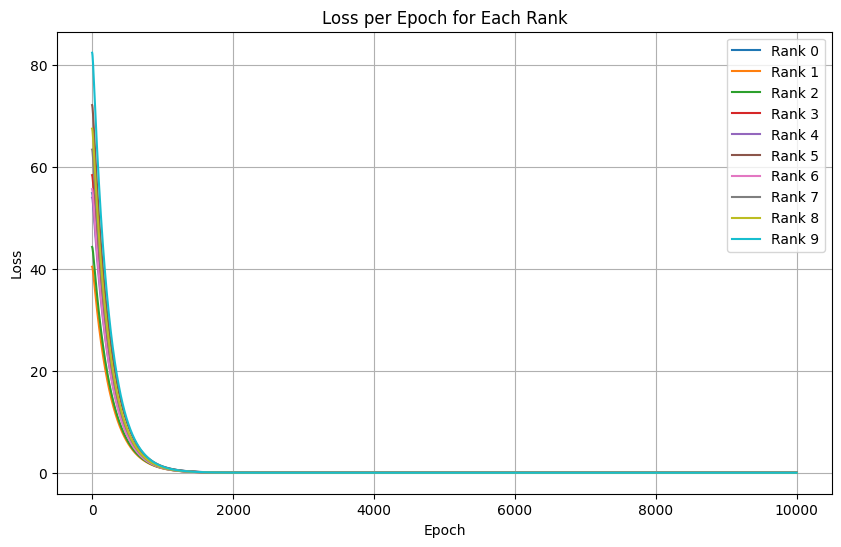

In [174]:
#load the loss pt fiels and plot them
import torch
import matplotlib.pyplot as plt
losses = []
for rank in range(10):
    try:
        loss = torch.load(f"losses_rank_{rank}.pt")
        losses.append(loss)
    except FileNotFoundError:
        print(f"Loss file for rank {rank} not found.")
plt.figure(figsize=(10, 6))
for rank, loss in enumerate(losses):
    plt.plot(loss, label=f'Rank {rank}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch for Each Rank')
plt.legend()
plt.grid()
plt.show()

Rank 0 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 1 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 2 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 3 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 4 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 5 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 6 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 7 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 8 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112
Rank 9 - Weights: [[2.0000109672546387], [-3.000688076019287]], Bias: 4.9995, MSE: 0.000112

Selected model from rank 0 with MSE: 0.000112
Final model - Weights: [[2.000010

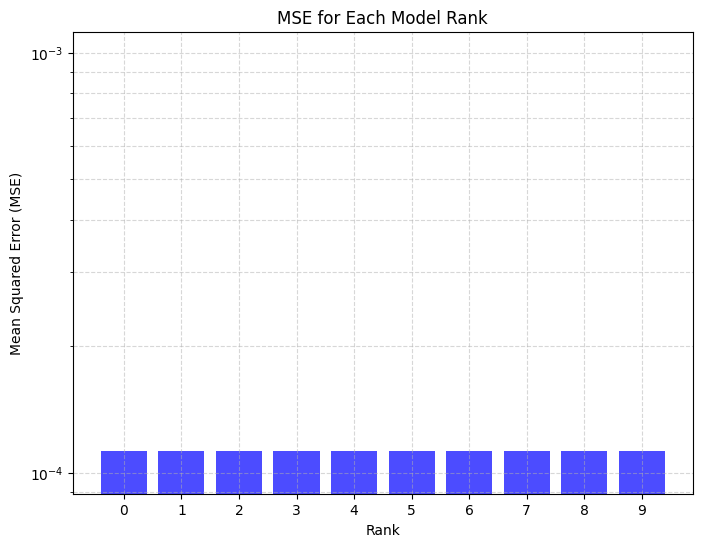

Final model MSE on test data: 0.000112


In [177]:
import torch
import matplotlib.pyplot as plt

# Generate test data (same as training)
N = 200
torch.manual_seed(0)
x1 = torch.linspace(-5, 5, N)
x2 = torch.randn(N) * 2  # Independent random values for x2
X = torch.stack((x1, x2), dim=1)  # shape (N, 2)

# Normalize input features (same as training)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# Define true weights and bias
true_w = torch.tensor([[2.0], [-3.0]])  # shape (2, 1)
bias = 5.0
y = X @ true_w + bias + torch.randn(N, 1) * 0.01  # shape (N, 1)

# Load model parameters and compute MSE
mse_values = []
model_params = []
ranks = range(10)
for rank in ranks:
    try:
        params = torch.load(f"model_rank_{rank}.pt")
        w = params['w']
        b = params['b']
        # Compute predictions
        y_pred = X @ w + b
        mse = ((y_pred - y) ** 2).mean().item()
        model_params.append(params)
        mse_values.append(mse)
        print(f"Rank {rank} - Weights: {w.tolist()}, Bias: {b.item():.4f}, MSE: {mse:.6f}")
    except FileNotFoundError:
        print(f"Model file for rank {rank} not found.")
        model_params.append(None)
        mse_values.append(None)

# Select the final model (lowest MSE or rank 0 if all are similar)
valid_mses = [mse for mse in mse_values if mse is not None]
valid_ranks = [r for r, mse in zip(ranks, mse_values) if mse is not None]
if not valid_mses:
    raise ValueError("No valid model files found.")
best_rank = valid_ranks[valid_mses.index(min(valid_mses))]
final_params = model_params[best_rank]
print(f"\nSelected model from rank {best_rank} with MSE: {mse_values[best_rank]:.6f}")
print(f"Final model - Weights: {final_params['w'].tolist()}, Bias: {final_params['b'].item():.4f}")

# Save the final model
torch.save(final_params, "final_model.pt")

# Plot MSE for each rank
plt.figure(figsize=(8, 6))
plt.bar(valid_ranks, valid_mses, color='blue', alpha=0.7)
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Model Rank')
plt.yscale('log')  # Log scale for small MSE values
plt.xticks(valid_ranks)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Example: Use the final model for predictions
# Load final model
final_model = torch.load("final_model.pt")
w_final = final_model['w']
b_final = final_model['b']
# Predict on test data
y_pred_final = X @ w_final + b_final
final_mse = ((y_pred_final - y) ** 2).mean().item()
print(f"Final model MSE on test data: {final_mse:.6f}")